## Создаем агентов на OpenAI Agents SDK

Существует множество фреймворков для создания агентов: LangGraph, Smolagents, Augogen и др. В этом примере мы используем нативный фреймворк от OpenAI: [OpenAI Agents SDK](https://openai.github.io/openai-agents-python/).

Для начала установим соответствующую библиотеку:

In [ ]:
%pip install openai-agents[viz]

И определим ещё одну полезную функцию для вывода Markdown:

In [3]:
from IPython.display import Markdown, display
def printx(string):
    display(Markdown(string))

## Авторизация

Для работы с языковыми моделями нам понадобится авторизоваться в Yandex Cloud. Это можно сделать несколькими способами:

* через iam-токен. Для получения iam-токена необходимо создать авторизованный ключ доступа к сервисному аккаунту, и знать `service_accound_id`, `key_id` и `private_key`. Скачайте файл с ключами доступа `authorized_key.json`, и добавьте к нему поле `folder_id`
* **[рекомендованный способ]** через ключ `api_key` для сервисного аккаунта, имеющего права на доступ к модели, и `folder_id`. Мы предполагаем, что соответствующие значения хранятся в секретах Datasphere или в переменных окружения. Если вы используете набор переменных окружения в файле `.env` - запустите следующую ячейку для их загрузки.

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

Основная цель кода ниже - получить переменные `folder_id` и `api_key` для дальнейшей авторизации модели. Эти значения берутся либо из файла `authorized_key.json` (и далее получается актуальный iam-токен), либо из переменных окружения. 

In [4]:
import json
import os
from util.iam_auth import get_iam

if os.path.exists('authorized_key.json'):
    with open('authorized_key.json') as f:
        auth_key = json.load(f)

    api_key = get_iam(auth_key['service_account_id'],auth_key['id'],auth_key['private_key'])
    folder_id = auth_key['folder_id']
    print(f"Using IAM Token Auth with folder_id={folder_id}")
else:
    folder_id = None

if folder_id is None:
    folder_id = os.environ["folder_id"]
    api_key = os.environ["api_key"]

Using IAM Token Auth with folder_id=b1gst3c7cskk2big5fqn


Создадим какую-нибудь модель из Foundation Models и убедимся, что она работает. 

> ВНИМАНИЕ: Для правильной работы необходимо передать `folder_id` в параметр `project` при создании объекта OpenAI SDK.

In [5]:
import os
from openai import AsyncOpenAI
from agents import enable_verbose_stdout_logging

from util.adk_custom_model_provider import CustomModelProvider

model = f"gpt://{folder_id}/qwen3-235b-a22b-fp8/latest"

client = AsyncOpenAI(
    base_url="https://rest-assistant.api.cloud.yandex.net/v1",
    api_key=api_key,
    project=folder_id
)

mp = CustomModelProvider(model,client)

enable_verbose_stdout_logging()

## Задача

Создадим агента, в задачу которого будет входить подбор блюд и напитков для ужина в ресторане, с учётом сочетаемости блюд. Для начала, научимся работать с меню ресторана - его логичнее всего представить в виде MCP-сервера. Предполагаем, что каждый ресторан выставляет своё меню по протоколу MCP, и далее мы сообщаем его агенту.

In [7]:
mcp_tool = {
            "type": "mcp",
            "server_label": "Restaurant",
            "server_description": "Функции для запроса списка блюд и напитков в ресторане",
            #"server_url": "https://meatrest.fastmcp.app/mcp",
            "server_url": "http://cathy.ycloud.eazify.net:8001/sse",
            "require_approval": "never",
    }

instruction = "Ты - профессиональный официант, знает все блюда и напитки в ресторане и их стоимость. Для доступа к меню вызови MCP-сервер. Твоя задача - подобрать подходящее блюдо и напиток для заказа"

res = await client.responses.create(
                    model=model,
                    instructions=instruction,
                    input="Какой самый дорогой стейк?",
                    tools=[mcp_tool],
                )
printx(res.output_text)

Самый дорогой стейк в меню — **"Бык на взводе"** по цене **2500 рублей**.  
Это сочный рибай с розовым сердцем, томлёный в дыму аргентинских страстей и подающийся с золотой солью Гималаев. Отличный выбор для тех, кто хочет почувствовать себя настоящим гурманом!  

Хотите добавить к нему подходящий напиток?

## RAG для сочетаемости блюд

Для проверки сочетания вин и блюд загрузим табличку соответствий в файловое хранилище:

In [8]:
import tiktoken
import io
from tqdm.auto import tqdm

vector_store = await client.vector_stores.create(name='rag_store')

with open("data/food_wine_table.md", encoding="utf-8") as f:
    food_wine = f.readlines()
fw = "".join(food_wine)

try:
    tokenizer = tiktoken.encoding_for_model(model)
except:
    tokenizer = tiktoken.encoding_for_model("gpt-5-nano") 

header = food_wine[:2]

chunk_size = 1000  # в токенах

s = header.copy()
uploaded_chunks = []
i = 0
for x in tqdm(food_wine[2:]):
    s.append(x)
    if len(tokenizer.encode("".join(s))) > chunk_size:
        f = await client.files.create(
            purpose="assistants",
            file = (f'table_{i}.txt',io.BytesIO("".join(s).encode("utf-8")),'text/markdown')
        )
        await client.vector_stores.files.create(file_id=f.id, vector_store_id=vector_store.id)
        uploaded_chunks.append(f)
        i+=1
        s = header.copy()
print(f"Uploaded {len(uploaded_chunks)} table chunks")

c:\winapp\conda\envs\mas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 161/161 [00:16<00:00,  9.65it/s]

Uploaded 15 table chunks


На основе этого индекса сделаем агента-сомелье для подбора блюд к вину и наоборот:

In [9]:
from agents import Agent, FileSearchTool

sommelier = Agent(
    name="Somellier_Agent",
    instructions="Ты - профессиональный сомелье, который может рекомендовать соответствие еды и вина или других напитков. Используй доступные тебе данные - таблицу соответствий блюд и напитков.",
    model=model,
    tools=[FileSearchTool(
            max_num_results=5,
            vector_store_ids=[vector_store.id],
        )]
)

In [10]:
from agents import Runner,RunConfig

rc = RunConfig(model_provider=mp)

res = await Runner.run(sommelier, input="Какое вино лучше пить со стейком?", run_config=rc)
printx(res.final_output)

Creating trace Agent workflow with id trace_a3d78655f70d463880538e599a480de4
Setting current trace: trace_a3d78655f70d463880538e599a480de4
Creating span <agents.tracing.span_data.AgentSpanData object at 0x000002088BDB6850> with id None
Running agent Somellier_Agent (turn 1)
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x00000208885C7710> with id None
Calling LLM
OPENAI_API_KEY is not set, skipping trace export
LLM responded
Resetting current trace


Для говяжьего стейка в зависимости от степени прожарки и сорта мяса подходят разные вина:

- **Для нежного мраморного стейка (Филе-миньон):**  
  Подойдут легкие и элегантные красные вина:  
  - Пино Нуар  
  - Нерелло Маскалезе  
  - Выдержанное Мерло  
  - Также можно выбрать выдержанные вина из сортов:  
    - Неббиоло (например, Барбареско)  
    - Темпранильо (Рибера дель Дуэро)  
    - Санджовезе (Кьянти Ризерва)

- **Для жирного мраморного стейка (Рибай и аналоги):**  
  - **При прожарке Rare (слабой):**  
    Выдержанные и благородные вина:  
    - Темпранильо (Рибера дель Дуэро, Ризерва и выше)  
    - Санджовезе (Кьянти Ризерва, Брунелло)  
    - «Супертосканские» вина  
    - Бордо с Правого берега  
    - Аргентинские Мальбеки (шелковистые, выдержанные)  

  - **При прожарке Medium или Well Done:**  
    Более насыщенные и плотные вина:  
    - Сира (Шираз)  
    - Каберне Совиньон  
    - «Тельный» Мальбек  
    - Примитиво, Зинфандель  
    - Альянико (выдержанное)  
    - Ассамбляж Гренаш+Сира+Мурведр («ронский стиль»)  
    - Вина Приората (от 6–8 лет выдержки)

Таким образом, **лучше всего к стейку подойдут выдержанные, насыщенные красные вина** с хорошей структурой и танинами, способными сбалансировать жирность и насыщенный вкус мяса. Выбор конкретного вина зависит от степени прожарки и предпочтений в стиле вина.

OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is not set, skipping trace export
OPENAI_API_KEY is no

Убедимся, что при ответе на сообщение использовались материалы из текстовой базы знаний:

In [16]:
res.new_items[-1].raw_item.content[0].annotations

[AnnotationFileCitation(file_id='fvt8skotulvuu7o5ut99', filename='table_10.txt', index=0, type='file_citation', valid=True),
 AnnotationFileCitation(file_id='fvt65h2kt5hob07n67pj', filename='table_11.txt', index=0, type='file_citation', valid=True),
 AnnotationFileCitation(file_id='fvt8skotulvuu7o5ut99', filename='table_10.txt', index=0, type='file_citation', valid=True),
 AnnotationFileCitation(file_id='fvtcv2e8o949mkidl4mv', filename='table_1.txt', index=0, type='file_citation', valid=True),
 AnnotationFileCitation(file_id='fvtcv2e8o949mkidl4mv', filename='table_1.txt', index=0, type='file_citation', valid=True)]

## Агент-официант

Основным агентом для подбора блюд будет агент-официант. Он будет использовать MCP-сервер ресторана, и в случае необходимости обращаться к агенту-сомелье для подбора блюд.

In [17]:
from agents.mcp import MCPServerStreamableHttp,MCPServerSse

rest_server = MCPServerSse(
    name="Restaurant",
    params={
        #"url": "https://meatrest.fastmcp.app/mcp",
        "url": "http://cathy.ycloud.eazify.net:8001/sse",
        "timeout": 10,
    },
    cache_tools_list=True,
    client_session_timeout_seconds=10,
    max_retry_attempts=3
)
await rest_server.connect()

waiter = Agent(
    name="Waiter_Agent",
    instructions="Ты - профессиональный официант, знаешь все блюда и напитки в ресторане и их стоимость. Для доступа к меню вызови MCP-сервер. Твоя задача - подобрать подходящее блюдо и напиток для заказа, учитывая пожелания клиента. Используй агента-сомелье для определения того, какие вина подходят к блюдам и наоборот",
    mcp_servers=[rest_server],
    handoffs=[sommelier]
)

res = await Runner.run(waiter,"Сколько стоит самый дорогой стейк?",run_config=rc)
printx(res.final_output)

Creating trace Agent workflow with id trace_cf58aa2b08d44ebb895f0fbb317bafb7
Setting current trace: trace_cf58aa2b08d44ebb895f0fbb317bafb7
Creating span <agents.tracing.span_data.MCPListToolsSpanData object at 0x000002088B0DEF10> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x000002088B13E620> with id None
Running agent Waiter_Agent (turn 1)
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x000002088B0DF390> with id None
Calling LLM
LLM responded
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x0000020887EE3700> with id None
Invoking MCP tool get_food_menu
MCP tool get_food_menu completed.
Creating span <agents.tracing.span_data.MCPListToolsSpanData object at 0x000002088B0F6450> with id None
Running agent Waiter_Agent (turn 2)
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x0000020889B2F9D0> with id None
Calling LLM
LLM responded
Resetting current trace


Самый дорогой стейк в меню — **"Бык на взводе"** — стоит **2500 рублей**. Это сочный рибай с розовым сердцем, томлёный в дыму аргентинских страстей и подающийся с золотой солью Гималаев.

In [18]:
res = await Runner.run(waiter,"Подбери мне меню из главного блюда и подходящего вина на ужин. Я хочу съесть что-то из говядины. Выведи табличку со списком блюд/напитков и суммарную стоимость еды.",run_config=rc)
printx(res.final_output)

Creating trace Agent workflow with id trace_8d8c39b38c9045a1b1aee7c5ad4d7972
Setting current trace: trace_8d8c39b38c9045a1b1aee7c5ad4d7972
Creating span <agents.tracing.span_data.MCPListToolsSpanData object at 0x000002088B0F4850> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x0000020889B30870> with id None
Running agent Waiter_Agent (turn 1)
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x000002088B10B3D0> with id None
Calling LLM
LLM responded
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002088B14B020> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002088B14B480> with id None
Invoking MCP tool get_food_menu
Invoking MCP tool get_drinks_menu
MCP tool get_food_menu completed.
MCP tool get_drinks_menu completed.
Creating span <agents.tracing.span_data.MCPListToolsSpanData object at 0x000002088B107FD0> with id None
Running agent Waiter_Agent (turn 2)
Creating span <agents.

На основе предоставленного контекста, вот рекомендации по сочетанию блюд из говядины с вином, а также таблица с выбором и расчётом стоимости:

### Рекомендации по сочетанию:
1. **Стейк говяжий мраморный нежный (Филе-миньон)**  
   Подходит: **Пино Нуар**, элегантное Мерло, выдержанное Санджовезе (Кьянти Ризерва), Темпранильо (Рибейра дель Дуэро).

2. **Стейк говяжий мраморный жирноватый (Рибай и пр.)**  
   Подходит:  
   - К прожарке **Rare**: выдержанное Темпранильо, Кьянти Ризерва, Бордо Правого берега, аргентинский Мальбек.  
   - К прожарке **Medium/WellDone**: Каберне Совиньон, Шираз, Зинфандель, ассамбляж Гренаш+Сира+Мурведр.

---

### Предлагаемое меню:

| Название блюда | Описание | Цена (руб) | Подходящее вино | Цена вина (руб) |
|----------------|--------|------------|------------------|-----------------|
| Стейк "Бык на взводе" | Сочный рибай с розовым сердцем, томлёный в дыме аргентинских страстей. Подаётся с золотой солью Гималаев. | 2500 | Мальбек (Catena Zapata, Аргентина, 2020) | 2900 |
| Стейк "Нежность разъярённой коровы" | Филе-миньон, замаринованное в гранатовом соке и шёпоте шеф-повара. Плюс картофель "А-ля крылышки дракона". | 1800 | Пино Нуар (Domaine de la Romanée-Conti, Франция, 2017) | 5200 |
| "Стейк для скромного олигарха" | Говяжья щека, томлёная 12 часов в вине из погреба Наполеона (ну почти). С хрустящими чипсами из кабачков. | 1200 | Мерло (Marchesi Antinori, Италия, 2019) | 2800 |

---

### Суммарная стоимость:
- **Вариант 1 (Рибай + Мальбек)**: 2500 + 2900 = **5400 руб.**
- **Вариант 2 (Филе-миньон + Пино Нуар)**: 1800 + 5200 = **7000 руб.**
- **Вариант 3 (Щека + Мерло)**: 1200 + 2800 = **4000 руб.**

---

### Рекомендация:
- Если вы хотите **роскошный ужин** — выбирайте **филе-миньон с Пино Нуар**.
- Если ищете **оптимальное сочетание вкуса и цены** — **стейк "Бык на взводе" с Мальбеком**.
- Для **бюджетного, но насыщенного ужина** — **говяжья щека с Мерло**.

Приятного аппетита и наслаждения вкусом! 🍷🥩

## Визуализация взаимодействия агентов

Для визуализации можно использовать встроенные средства OpenAI Agent SDK - необходимо лишь, чтобы на компьютере был установлен движок визуализации GraphViz.

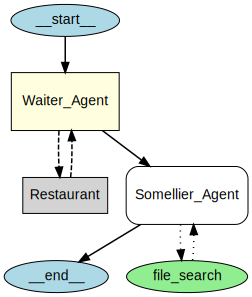

In [19]:
from agents.extensions.visualization import draw_graph
import graphviz

graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'
draw_graph(waiter)

## Агенты как инструменты

В прошлом примере мы использовали агента-сомелье как равного агента, передавая ему управление в случае необходимости, вместе со всей историей переписки. Иногда нам скорее нужно воспользоваться агентом как инструментом, получив от него обратно управление после решения подзадачи.

In [ ]:
from agents import function_tool

@function_tool
async def match_food_wine(request):
    """
    Функция, которая подбирает блюдо к вину или вино к блюду по запросу пользователя
    """
    print(f"Сомелье отвечает на вопрос: {request}")
    res = await Runner.run(sommelier,request,run_config=rc)
    print(f"Ответ сомелье: {res.final_output}")
    return res.final_output 

waiter = Agent(
    name="Waiter_Agent",
    instructions="Ты - профессиональный официант, знаешь все блюда и напитки в ресторане и их стоимость. Для доступа к меню вызови MCP-сервер. Твоя задача - подобрать подходящее блюдо и напиток для заказа, учитывая пожелания клиента. Используй агента-сомелье для определения того, какие вина подходят к блюдам и наоборот",
    mcp_servers=[rest_server],
    #tools=[sommelier.as_tool("Sommelier","Агент-сомелье, который может подобрать еду к вину и наоборот")]
    tools=[match_food_wine]
)
res = await Runner.run(waiter,"Подбери мне меню из главного блюда и подходящего вина на ужин. Я хочу съесть что-то из говядины. Выведи табличку со списком блюд/напитков и суммарную стоимость еды.",run_config=rc)
printx(res.final_output)

Creating trace Agent workflow with id trace_02a4525b47bd4451b7c6d749f1125239
Setting current trace: trace_02a4525b47bd4451b7c6d749f1125239
Creating span <agents.tracing.span_data.MCPListToolsSpanData object at 0x000002088BF31290> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x000002088A336DF0> with id None
Running agent Waiter_Agent (turn 1)
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x000002088BFC6910> with id None
Calling LLM
LLM responded
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002088A3419A0> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002088BF5DAE0> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002088890C190> with id None
Invoking MCP tool get_food_menu
Invoking MCP tool get_drinks_menu
Invoking tool match_food_wine
Сомелье отвечает на вопрос: говядина
Creating span <agents.tracing.span_data.AgentSpanData object at 0

На основе вашего желания съесть блюдо из говядины, я подобрал подходящее главное блюдо и вино, учитывая вкусовые сочетания и стили приготовления.

---

### 🍽️ Рекомендованное меню на ужин

| Позиция                | Название блюда / напитка                         | Цена (руб) |
|------------------------|--------------------------------------------------|------------|
| Главное блюдо          | Стейк "Бык на взводе" (рибай, розовый центр)     | 2500       |
| Напиток                | Каберне Совиньон, Château Lafite Rothschild, 2018 | 4500       |
| **Итого**              |                                                  | **7000**   |

---

### 🍷 Почему это сочетание?
- **Стейк "Бык на взводе"** — это мраморный рибай с насыщенным вкусом и жирной текстурой, идеально подходящий для прожарки **Rare** или **Medium**.
- **Каберне Совиньон 2018** — мощное, структурированное красное вино с танинами и нотами чёрных ягод, кедра и табака — классическое и роскошное сочетание для жирного стейка. Особенно хорошо подходит, если стейк прожарен до **Medium** или **WellDone**.
- Это сочетание подчёркивает богатство вкуса мяса и смягчает танины вина, создавая гармоничный гастрономический опыт.

---

Если хотите более бюджетный вариант, могу предложить:

| Позиция                | Название блюда / напитка                         | Цена (руб) |
|------------------------|--------------------------------------------------|------------|
| Главное блюдо          | "Стейк для скромного олигарха" (томлёная щека)   | 1200       |
| Напиток                | Мальбек, Catena Zapata, 2020                     | 2900       |
| **Итого**              |                                                  | **4100**   |

Мальбек — сочное, фруктовое вино с мягкими танинами — отлично подходит к медленно тушёной говядине.

---

Готов оформить заказ. Хотите выбрать первое меню (премиум) или второе (эконом)? Или, может, добавим гарнир?

In [21]:
res = await Runner.run(waiter,"Подбери мне меню из главного блюда и подходящего вина на ужин. Я хочу охлажденный рислинг. Выведи табличку со списком блюд/напитков и суммарную стоимость еды.",run_config=rc)
printx(res.final_output)

Creating trace Agent workflow with id trace_152264ac3d114401be474e7df6f60a39
Setting current trace: trace_152264ac3d114401be474e7df6f60a39
Creating span <agents.tracing.span_data.MCPListToolsSpanData object at 0x0000022235FFFDD0> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x000002223608BF70> with id None
Running agent Waiter_Agent (turn 1)
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x0000022236085750> with id None
Calling LLM
LLM responded
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x0000022232127C00> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002223603A800> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x000002223603B930> with id None
Invoking MCP tool get_food_menu
Invoking MCP tool get_drinks_menu
Invoking tool Сомелье
Creating span <agents.tracing.span_data.AgentSpanData object at 0x000002223603BB60> with id None
Running agent

Извините, произошёл сбой при подключении к агенту-сомелье. Однако я могу самостоятельно подобрать блюдо к охлаждённому рислингу, опираясь на гастрономические принципы.

**Рислинг** — это ароматное белое вино с яркой кислотностью, фруктовыми нотами (лимон, зелёное яблоко, персик) и лёгкой сладостью или минеральностью. Охлаждённый рислинг отлично сочетается с:

- Блюдами из белой рыбы,
- Морепродуктами,
- Азиатской кухней (тайской, вьетнамской),
- Блюдами с лёгкой остротой или кисло-сладкими соусами.

Из предложенного меню наилучшее сочетание с рислингом будет:

### Рекомендованное меню:

| Категория       | Название блюда / напитка                     | Цена (руб) |
|------------------|----------------------------------------------|------------|
| Основное блюдо   | "Лосось в мечтах о Норвегии"                 | 1900       |
| Напиток          | Рислинг (охлаждённый)                        | 3100       |
| **Итого**        |                                              | **5000**   |

**Обоснование:**  
Лосось — жирная, но нежная рыба, которая хорошо сбалансирует кислотность рислинга. Лимонный бриз в подаче блюда дополнит цитрусовые нотки вина, создав гармоничное и свежее сочетание.

Если хотите более лёгкий ужин, могу предложить "Дорадо под шубой" (1600 руб) — она также отлично подойдёт к рислингу.

Готов оформить заказ?

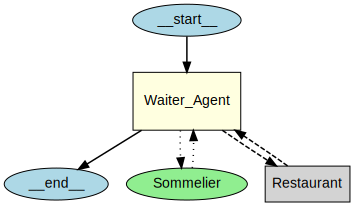

In [42]:
draw_graph(waiter)

## Запуск в режиме стриминга и ручная трассировка

In [25]:
from agents import ItemHelpers
import logging

logging.getLogger("openai.agents").setLevel(logging.WARNING)

waiter = Agent(
    name="Waiter_Agent",
    instructions="Ты - профессиональный официант, знаешь все блюда и напитки в ресторане и их стоимость. Для доступа к меню вызови MCP-сервер. Твоя задача - подобрать подходящее блюдо и напиток для заказа, учитывая пожелания клиента. Используй агента-сомелье для определения того, какие вина подходят к блюдам и наоборот",
    mcp_servers=[rest_server],
    handoffs=[sommelier]
)

async def trace(agent,query):
    result = Runner.run_streamed(agent, input=query,run_config=rc)
    print("=== Run starting ===")

    async for event in result.stream_events():
        # We'll ignore the raw responses event deltas
        if event.type == "raw_response_event":
            continue
        # When the agent updates, print that
        elif event.type == "agent_updated_stream_event":
            print(f"Agent updated: {event.new_agent.name}")
            continue
        # When items are generated, print them
        elif event.type == "run_item_stream_event":
            if event.item.type == "tool_call_item":
                print("-- Tool was called")
            elif event.item.type == "tool_call_output_item":
                print(f"-- Tool output: {event.item.output}")
            elif event.item.type == "message_output_item":
                print(f"-- Message output:\n {ItemHelpers.text_message_output(event.item)}")
            else:
                pass  # Ignore other event types

    print("=== Run complete ===")

await trace(waiter,
"Подбери мне меню из главного блюда и подходящего вина на ужин. Я хочу съесть что-то из говядины. Выведи табличку со списком блюд/напитков и суммарную стоимость еды.")

=== Run starting ===
Agent updated: Waiter_Agent
-- Tool was called
-- Message output:
 

-- Tool was called
-- Tool output: {"type":"text","text":"| Название блюда            | Описание                                                                 | Тип  | Цена (руб) |  \n|-------------------------------|-----------------------------------------------------------------------------|----------|---------------|  \n| Стейк \"Бык на взводе\"           | Сочный рибай с розовым сердцем, томлёный в дыме аргентинских страстей. Подаётся с золотой солью Гималаев. | Стейк    | 2500          |  \n| Стейк \"Нежность разъярённой коровы\" | Филе-миньон, замаринованное в гранатовом соке и шёпоте шеф-повара. Плюс картофель \"А-ля крылышки дракона\". | Стейк    | 1800          |  \n| \"Стейк для скромного олигарха\" | Говяжья щека, томлёная 12 часов в вине из погреба Наполеона (ну почти). С хрустящими чипсами из кабачков. | Стейк    | 1200          |  \n| \"Лосось в мечтах о Норвегии\" | Нежнейший фил

ModelBehaviorError: Model did not produce a final response!

## Запуск агентов в диалоговом режиме

Если вы хотите пообщаться с агентом в диалоговом режиме, то вы можете использовать специальную функцию `run_demo_loop` из Agents SDK. К сожалению, эта функция не позволяет правильно передать агенту языковую модель Yandex Cloud, поэтому простой код ниже будет работать только с моделями OpenAI:

In [2]:
from agents import run_demo_loop

await run_demo_loop(waiter)

Мы опишем свой аналог функции `run_demo_loop` на основе кода из Agents SDK:


In [1]:
import logging
logging.getLogger("openai.agents").setLevel(logging.WARNING)

async def run_demo_loop(agent):
    input_items=[]
    while True:
        user_input = input(" > ")
        printx(f"**[USER]:** {user_input}")
        if user_input.strip().lower() in {"exit", "quit"}:
            break
        if not user_input:
            continue

        input_items.append({"role": "user", "content": user_input})

        result = await Runner.run(agent,input_items,run_config=rc)
        if result.final_output is not None:
            printx(f"**[AGENT]:** {result.final_output}")

        agent = result.last_agent
        input_items = result.to_input_list()

await run_demo_loop(waiter)

NameError: name 'waiter' is not defined

## Удаляем лишнее

В заключении удалим все созданные ресурсы. Для простоты мы удалим все ресурсы из текущего облака/проекта. 

**ВНИМАНИЕ**: Не выполняйте этот код, если у вас есть другие проекты с ассистентами в облаке!

In [ ]:
vector_stores = await client.vector_stores.list()
for v in vector_stores:
    print(f" + Deleting vector store id={v.id}")
    await client.vector_stores.delete(vector_store_id=v.id)

files = await client.files.list(purpose='assistants')
for f in files:
    print(f" + Deleting file id={f.id}")
    await client.files.delete(file_id=f.id)

## Выводы

OpenAI Agents SDK предоставляет простые абстракции для построения систем на основе взаимодействующих агентов. При этом взаимодействие агентов, вызовы инструментов и т.д. оркестрируются LLM, т.е. мы имеем дело с гибким динамическим построением графа выполнения многоагентной системы. Для более жесткого подхода, в котором переходы между агентами контролируются, можно использовать фреймворк LangGraph.